<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/BBC_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [5]:
#librerias
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers, backend

Using TensorFlow backend.


In [0]:
# pip install nltk

In [3]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package brown to /root/nltk_data...
       |   Package brown is already up-to-date!
       | Downloading package brown_tei to /root/nltk_data...
       |   Package brown_tei is already up-to-date!
       | Downloading package cess_cat to /root/nltk_data...
       |   Package cess_cat is already up-to-date!
       | Down

True

In [0]:
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize

# Define algunas características iniciales

In [0]:
vocab_size = 37069 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 120  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [8]:
complete_sentences = []
complete_lines = [] 
sentences = []
labels = [] # preprocesed labels

stopwords = []
print(len(stopwords))

0


In [9]:
import string
import numpy as np

a = np.array([32]) # space
#b = np.array(range(65,91)) # uppercase
c = np.array(range(97,123)) # lowercase
printab = np.hstack((a,c))

printable = np.array([chr(i) for i in printab])   
printable

#ascci_to_char = dict((printab[i], printable[i]) for i in range(len(printable)))

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

In [12]:
#lectura de los datos
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))
# Expected Output
# 158314

69171
69171
69171
69171


In [46]:
# primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Expected Output
# 158314
# 158314

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom



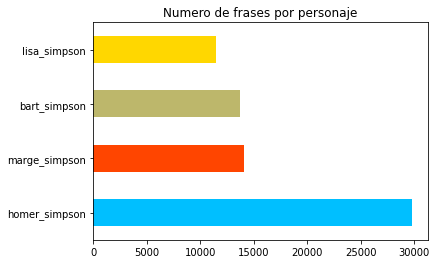

In [47]:
#Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [48]:
sentences[:4]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom']

# Separa datos de entrenamiento y validación 

In [49]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 126651 train
# 31663 validation

55336
55336
55336
13835
13835


In [50]:
train_sentences[:3]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide']

In [51]:
train_labels[:3]

['lisa_simpson', 'lisa_simpson', 'bart_simpson']

# Tokens

In [0]:
#juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

In [53]:
#para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['wheres',
 'mr',
 'bergstrom',
 'that',
 'life',
 'is',
 'worth',
 'living',
 'victory',
 'party']

In [54]:
#para generar n-gramas
from nltk.util import ngrams
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['wheres mr bergstrom',
 'mr bergstrom that',
 'bergstrom that life',
 'that life is',
 'life is worth']

In [55]:
len(trigrama)

477691

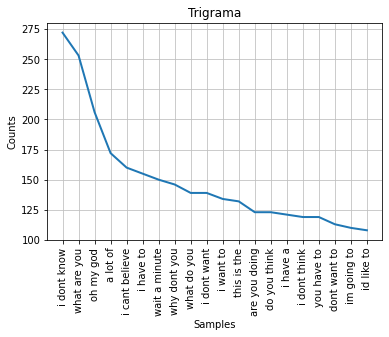

In [56]:
#grafica con los trigramas
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens
freqnew = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (val>1):
    freqnew.append(str(key))
freq.plot(20, cumulative=False, title = "Trigrama")

In [57]:
len(freqnew)

37069

In [0]:
##para generar n-gramas
#from nltk.util import ngrams
#cuatrigrama = ngrams(tokenstk,4)
#cuatrigrama = [ ' '.join(grams) for grams in cuatrigrama]

In [0]:
#grafica con los cuatrigramas
#freq = nltk.FreqDist(cuatrigrama)
#freq.plot(20, cumulative=False, title = "cuatrigrama")

In [0]:
#print(len(cuatrigrama))

# Vocabulario

In [61]:
help(Tokenizer)

Help on class Tokenizer in module keras_preprocessing.text:

class Tokenizer(builtins.object)
 |  Text tokenization utility class.
 |  
 |  This class allows to vectorize a text corpus, by turning each
 |  text into either a sequence of integers (each integer being the index
 |  of a token in a dictionary) or into a vector where the coefficient
 |  for each token could be binary, based on word count, based on tf-idf...
 |  
 |  # Arguments
 |      num_words: the maximum number of words to keep, based
 |          on word frequency. Only the most common `num_words-1` words will
 |          be kept.
 |      filters: a string where each element is a character that will be
 |          filtered from the texts. The default is all punctuation, plus
 |          tabs and line breaks, minus the `'` character.
 |      lower: boolean. Whether to convert the texts to lowercase.
 |      split: str. Separator for word splitting.
 |      char_level: if True, every character will be treated as a token.


### Ejemplo con 7 frases

In [62]:
train_sentences[:7]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom',
 'do you know where i could find him',
 'the train how like him traditional yet environmentally sound',
 'i see he touched you too']

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3,3))

In [64]:
X = vectorizer3.fit_transform(train_sentences[:7])
X

<7x24 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [65]:
F = vectorizer3.get_feature_names() #Array mapping from feature integer indices to feature name.
vectorizer3.decode(F) #Decode the input into a string of unicode symbols.

['bergstrom mr bergstrom',
 'could find him',
 'do you know',
 'he touched you',
 'him traditional yet',
 'how like him',
 'is worth living',
 'know where could',
 'life is worth',
 'like him traditional',
 'mr bergstrom mr',
 'party under the',
 'see he touched',
 'that life is',
 'the train how',
 'touched you too',
 'traditional yet environmentally',
 'train how like',
 'under the slide',
 'victory party under',
 'where could find',
 'wheres mr bergstrom',
 'yet environmentally sound',
 'you know where']

In [66]:
print('Vocabulary:')
print(vectorizer3.vocabulary_)

Vocabulary:
{'wheres mr bergstrom': 21, 'that life is': 13, 'life is worth': 8, 'is worth living': 6, 'victory party under': 19, 'party under the': 11, 'under the slide': 18, 'mr bergstrom mr': 10, 'bergstrom mr bergstrom': 0, 'do you know': 2, 'you know where': 23, 'know where could': 7, 'where could find': 20, 'could find him': 1, 'the train how': 14, 'train how like': 17, 'how like him': 5, 'like him traditional': 9, 'him traditional yet': 4, 'traditional yet environmentally': 16, 'yet environmentally sound': 22, 'see he touched': 12, 'he touched you': 3, 'touched you too': 15}


In [67]:
print("arreglo",X.toarray())
print("longitud",len(X.toarray()))

arreglo [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]
longitud 7


In [68]:
import pandas as pd
pd.DataFrame(X.toarray(),columns=vectorizer3.get_feature_names())

,bergstrom mr bergstrom,could find him,do you know,he touched you,him traditional yet,how like him,is worth living,know where could,life is worth,like him traditional,mr bergstrom mr,party under the,see he touched,that life is,the train how,touched you too,traditional yet environmentally,train how like,under the slide,victory party under,where could find,wheres mr bergstrom,yet environmentally sound,you know where
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
5,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0
6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [69]:
#función inversa
print('To the source:')
print(vectorizer3.inverse_transform(X.toarray()))

To the source:
[array(['wheres mr bergstrom'], dtype='<U31'), array(['is worth living', 'life is worth', 'that life is'], dtype='<U31'), array(['party under the', 'under the slide', 'victory party under'],
      dtype='<U31'), array(['bergstrom mr bergstrom', 'mr bergstrom mr'], dtype='<U31'), array(['could find him', 'do you know', 'know where could',
       'where could find', 'you know where'], dtype='<U31'), array(['him traditional yet', 'how like him', 'like him traditional',
       'the train how', 'traditional yet environmentally',
       'train how like', 'yet environmentally sound'], dtype='<U31'), array(['he touched you', 'see he touched', 'touched you too'],
      dtype='<U31')]


### Para todos los datos

In [0]:
#usamos CountVectorizer para convertir un texto en una matriz de tokens contados
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3,3))

In [71]:
#Learn the vocabulary dictionary and return document-term matrix.
X = vectorizer3.fit_transform(train_sentences)
X

<55336x282415 sparse matrix of type '<class 'numpy.int64'>'
	with 349694 stored elements in Compressed Sparse Row format>

In [72]:
F = vectorizer3.get_feature_names() #Array mapping from feature integer indices to feature name.
vectorizer3.decode(F) #Decode the input into a string of unicode symbols.

['aa meeting tonight',
 'aa meetings beer',
 'aaa no im',
 'aaaaaahhhhhhhhh oh yes',
 'aaaand were out',
 'aaagh him again',
 'aaagh man lips',
 'aaah whats the',
 'aaannnnd initial here',
 'aagh my ovaries',
 'aah oh good',
 'aah the college',
 'aahhh unclean unclean',
 'aannd round and',
 'aannnnd krusty hey',
 'aapple to zzebra',
 'aaron aaronson voted',
 'aaronson voted for',
 'aarp well that',
 'aba whos your',
 'abandon his family',
 'abandon hope or',
 'abandon my route',
 'abandon the metric',
 'abandon you in',
 'abandoned amusement park',
 'abandoned but not',
 'abandoned greenhouse outside',
 'abandoned her amber',
 'abandoned her nest',
 'abandoned prison all',
 'abandoned since nineteen',
 'abandoned us they',
 'abandoned you for',
 'abandoning everything believed',
 'abandoning your child',
 'abbey so it',
 'abbiamo avuto qualcosa',
 'abbreviate each letter',
 'abby says seeing',
 'abby the olympic',
 'abc cbs uhoh',
 'abc its the',
 'abc whats gotten',
 'abcs tgif lineup

In [0]:
#imprime el vector final
#X.toarray()

In [74]:
# Now, we can inspect how our vectorizer vectorized the text
# This will print out a list of words used, and their index in the vectors
print('Vocabulary: ')
print(vectorizer3.vocabulary_)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
#tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok,split= ' ')
#tokenizer.fit_on_texts(train_sentences)
#word_index = tokenizer.word_index

#train_sequences = tokenizer.texts_to_sequences(train_sentences)
#train_padded = np.array(pad_sequences(train_sequences, padding=padding_type, maxlen=max_length))

In [0]:
#word_index

In [0]:
print((train_sequences[0]))
print(len(train_padded[0]))

#print(len(train_sequences[1]))
#print(len(train_padded[1]))

#print(len(train_sequences[10]))
#print(len(train_padded[10]))

# Expected Ouput
# 12
# 120
# 3
# 120
# 10
# 120

[370, 144, 1]
120


In [0]:
train_sequences[:2]

[[370, 144, 1], [10, 156, 12, 814, 582]]

In [0]:
train_padded[:2]

array([[370, 144,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 10, 156,  12, 814, 582,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))


In [0]:
validation_sequences[:2]

# Expected output
# 31663
# (31663, 120)

[[], [260, 1, 1, 35, 3, 68, 30, 6, 15]]

In [0]:
validation_padded[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [260,   1,   1,  35,   3,  68,  30,   6,  15,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [0]:
print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 31663
# (31663, 120)

13835
(13835, 120)


In [0]:
label_size = 500
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq[3])
print(training_label_seq[5])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq[3])
print(validation_label_seq[5])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[5]
[5]
[4]
[5]
[5]
(55336, 1)
[2]
[2]
[2]
[2]
[4]
(13835, 1)


In [0]:
# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])


In [0]:
label_seq[:5]

array([5, 5, 4, 5, 5])

In [0]:
max(validation_label_seq)

5

# transform target to one-hot codification

## primero crea etiquetas numéricas

In [0]:
from sklearn. preprocessing import LabelEncoder
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
y_train = encoder.transform(training_label_seq)
y_test = encoder.transform(validation_label_seq)

In [0]:
max(y_train)

3

In [0]:
y_train.shape

(55336,)

In [0]:
y_train

array([3, 3, 2, ..., 0, 0, 1])

In [0]:
y_test

array([0, 0, 0, ..., 1, 3, 3])

## one hot

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
num_classes

4

In [0]:
y_train.shape

(55336, 4)

In [0]:
y_train[0]

array([0., 0., 0., 1.], dtype=float32)

In [0]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

## Modelo 1

| dropout | conv1D | LSTM | accuracyTrain | accuracyValidation | epoch |
|---------|:------:|:----:|:-------------:|:------------------:|:-----:|
|         |        |      |    0.3645     |       0.3478       |  13   |
|    1    |   1    |      |    0.3751     |       0.3462       |  11   |
|         |   1    |      |    0.3761     |       0.3455       |  10   |
|    1    |        |      |    0.3668     |       0.3527       |  15   |
|    1    |        |   1  |    0.3730     |       0.3416       |  13   |

## Modelo 2 con 9 Labels

| spatial Dropout1d | BIDLSTM | Dropout | Dense | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|::|::|::|::|::|::|::|::|::|
|1|2|2|2|1.2943|0.5236|1.5963|0.4304|23|



## Modelo 3 con 4 Labels - 20 ephocs

| Conv1D | SpatialDroout1D | BIDLSTM | Dropout | Densa | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| | |1|2|2|1.0705|0.5387|1.1504|0.4953|10|
|1|1||2|2|1.0209|0.5645|1.1661|0.4930|7|
|1||1|2|2|1.0497|0.5510|1.1570|0.4941|5|
||1|1|2|2|1.0601|0.5453|1.1625|0.4911|9|
|1|1|1|2|2|1.0479|0.5516|1.1565|0.4898|6|
|2| | |2|2|1.0265|0.5626|1.1968|0.4835|6|
| | | |2|2|1.0691|0.5402|1.1626|0.4978|10|
| | | |3|3|1.0789|0.5394|1.1517|0.4966|11|

In [0]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.Conv1D(120, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 32)           64000     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 116, 200)          32200     
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 112, 120)          120120    
_________________________________________________________________
global_average_pooling1d_15  (None, 120)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 120)               14520     
_________________________________________________________________
dropout_23 (Dropout)         (None, 120)             

## Entrenamos el modelo

In [0]:
num_epochs = 40
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[callback])
print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

Epoch 1/40
1730/1730 - 10s - loss: 1.2513 - accuracy: 0.4476 - val_loss: 1.2145 - val_accuracy: 0.4658
Epoch 2/40
1730/1730 - 9s - loss: 1.1632 - accuracy: 0.4955 - val_loss: 1.1536 - val_accuracy: 0.4891
Epoch 3/40
1730/1730 - 9s - loss: 1.1042 - accuracy: 0.5248 - val_loss: 1.1322 - val_accuracy: 0.5004
Epoch 4/40
1730/1730 - 9s - loss: 1.0678 - accuracy: 0.5419 - val_loss: 1.1429 - val_accuracy: 0.5031
Epoch 5/40
1730/1730 - 9s - loss: 1.0372 - accuracy: 0.5586 - val_loss: 1.1580 - val_accuracy: 0.4867
Epoch 6/40
1730/1730 - 10s - loss: 1.0051 - accuracy: 0.5756 - val_loss: 1.1747 - val_accuracy: 0.4880
Epoch 7/40
1730/1730 - 10s - loss: 0.9719 - accuracy: 0.5935 - val_loss: 1.2090 - val_accuracy: 0.4863

En la epoca 7 la precision de validación dejó de mejorar.


## Graficamos

In [0]:
string='accuracy'
print(history.history[string])
print(history.history['val_'+string])

[0.46470651030540466, 0.5170232653617859, 0.5339200496673584, 0.5419618487358093, 0.5499494075775146]
[0.49129021167755127, 0.5045175552368164, 0.5026382207870483, 0.5000361204147339, 0.495771586894989]


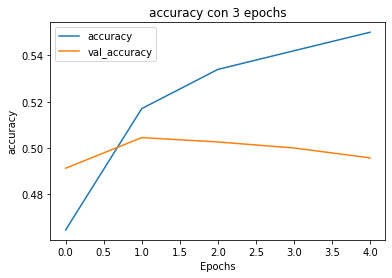

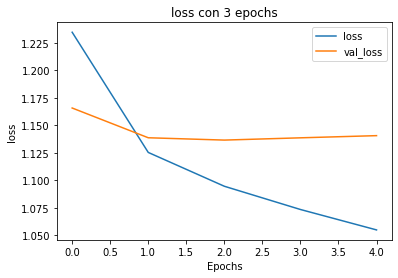

In [0]:
def plot_graphs(history, string):
  plt.title(string+' con 3 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
#convierte palabras en texto (NO LO USAMOS AÚN)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_sentence([862, 54])

In [0]:
#Pesos de la primera capa
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

In [0]:
weights

## funcion clasificadora

In [0]:
validation_sentences[:2]

In [0]:
sq = model.predict_classes(validation_padded[:2])
sq

In [0]:
label_tokenizer.sequences_to_texts([sq])

In [0]:
def classifier (sentence): 
  sentences = []
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)
  # preprocess stopwords
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  sentences.append(sentence)

  sentences = tokenizer.texts_to_sequences(sentences) #transforms each text in texts to a sequence of integers
  sentences_padded = np.array(pad_sequences(sentences, padding=padding_type, maxlen=max_length))

  #prob = model.predict(sentences_padded)
  prediction = model.predict_classes(sentences_padded)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [0]:
classifier('are you sure lord')

In [0]:
classifier('can his funeral be on a school day')

In [0]:
classifier("We should go to the bar")

## exportar archivos

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Referencias
- Aprendizaje profundo, [Ciencia de datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos/tree/master/Cuadernos)